# Winter 2019 Data Science Intern Challenge

## Question 1 Analysis

(*Scroll down to the end of Question 1 if you would prefer a summary of the answers found from the analysis below. Question 2 answers are there too.*)

In [2]:
#Load the data
library(tidyverse) #For dplyr and ggplot2
library(ggthemes)  #Used with ggplot2
library(lubridate) #For dates
library(repr)      #For sizing graphs

#Load the dataset
shopify <- read.csv("shopify.csv")

Notice that there's something curious happening when we inspect how many transactions are made for each transaction size:

In [3]:
items_count <- as.tibble(table(shopify$total_items))
colnames(items_count) <- c("total_items", "count_transactions")
items_count

total_items,count_transactions
1,1830
2,1832
3,941
4,293
5,77
6,9
8,1
2000,17


All of the transaction sizes are 8 items or smaller, except for the 17 of size 2000. It's likely that these excessively large transactions are driving up the AOV. Let's inspect this further.

In [4]:
manyItems <- shopify %>%
  filter(total_items==2000)

#Convert created_at from factor to dttm so we can order by date
manyItems$created_at <- ymd_hms(manyItems$created_at)

#Order by date
manyItems <- manyItems[order(manyItems$created_at),]
manyItems


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
3,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
15,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00
2,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
1,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
10,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00
6,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00
9,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00
5,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00
8,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00
7,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00


We see that all of the recorded transactions of size 2000 occurred from the same user_id (607) of the same shop_id (42), and that the order_amount is exactly the same in each case (704000). Moreover, we see that there are some days where there are multiple identical transactions, and all purchases are made at exactly 4 a.m., to the second. Either there was a mistake in the dataset with duplicate entries, or this customer is automating the process of buying shoes in bulk, which he or she will presumably sell at a higher price. <br />

There's also something fishy going on when we inspect the maximum order amount for the various transaction sizes:

In [5]:
shopify %>% 
  group_by(total_items) %>%
  summarise(mean_order_amount = round(mean(order_amount), 2), 
            max_order_amount = max(order_amount)) %>%
  mutate(fishy_observation = max_order_amount/total_items)


total_items,mean_order_amount,max_order_amount,fishy_observation
1,417.36,25725,25725
2,750.22,51450,25725
3,1191.08,77175,25725
4,947.69,102900,25725
5,759.35,1760,352
6,17940.00,154350,25725
8,1064.00,1064,133
2000,704000.00,704000,352


There are very large maximum order amounts for purchases of 1 item, 2 items, 3 items, 4 items and 6 items. Moreover, when each of these maximum order amounts is divided by the total items bought in its respective transaction, we get 25725. We would never expect an average pair of shoes to cost 25725, and therefore there is probably a specific recording mistake that is being repeated in the dataset. <br />

Now how do we handle these potential problems in our dataset? Let's take a look at a scatterplot which shows the order amount for each of our 5000 transactions. 

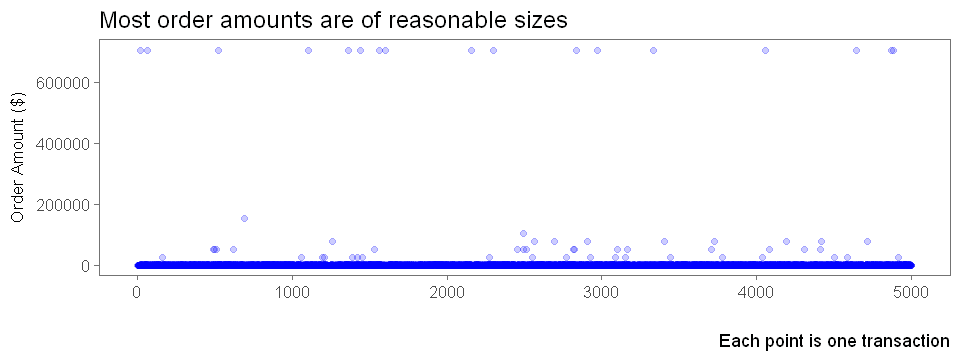

In [6]:
#Sizing the graph output
options(repr.plot.width=8, repr.plot.height=3)

#Creating the graph
shopify %>%
  ggplot(aes(x=order_id, y=order_amount)) +
  geom_point(color="blue", alpha=0.2) + 
  labs(x='', y="Order Amount ($)", title="Most order amounts are of reasonable sizes", caption="Each point is one transaction") +
  scale_y_continuous(breaks=200000*(0:3), labels=c('0', '200000', '400000', '600000')) +
  theme_few() + 
  theme(axis.title.y = element_text(size=10))

Notice that most of the transactions are along the dark blue line, which corresponds to purchases that are a few hundred or a few thousand dollars - plausible order amounts when buying at most 8 pairs of shoes. <br />

We saw that our original choice of evaluation metric, AOV, is largely affected by the numerous extreme values in this dataset, both from the 2000 item purchases and from the fishy order amounts that were multiples of 25725. To protect our evaluation metric from the effects of these outliers it would therefore be wise to instead use a robust evaluation metric, median, which will be found among the points in the dark blue line.

In [7]:
median(shopify$order_amount)

[1] 284

## Question 1 Answers (Summary)

**Question 1a.** <br />

•When using the AOV, we are blindly computing the average order amount without taking into account the number of pairs of shoes purchased in each transaction. <br />
•Moreover, there are many transactions that seem questionable/erroneous: <br />
-The 17 indentical transactions that included 2000 purchases each are driving up the AOV. <br />
-When we group transactions by total_items we see unlikely maximum order amounts that are multiples of 25725 for transaction sizes of 1, 2, 3, 4 and 6 items. These transactions are also driving up the AOV. <br />
•Due to the extreme points it would be preferable to use a robust evaluation metric (one which isn't affected by extreme values).


**Question 1b.** <br />
To protect our evaluation metric from the effects of extreme/erroneous points it would be wise to use a robust evaluation metric: median.

**Question 1c.** <br />
The median is 284, which is a more reasonable value for our measure of central tendancy than the mean (3145.13) given that we are talking about single-transaction purchases of shoes.

## Question 2 Answers

**Question 2a.** <br />
***Answer: 54***

SELECT COUNT(*) <br />
FROM Orders AS o, Shippers AS s <br /> 
WHERE o.ShipperId = s.ShipperId AND ShipperName = "Speedy Express";

**Question 2b.**<br />
***Answer: Handel <br />
(10 orders)***


SELECT c.CustomerName, COUNT(*) AS Count <br />
FROM Orders AS o, Customers AS c <br />
WHERE o.CustomerID = c.CustomerID <br />
GROUP BY o.CustomerID <br />
ORDER BY Count DESC <br />
LIMIT 1;

**Question 2c.** <br />
***Answer: Boston Crab Meat <br />
(ProductID: 40, TotalQuantity: 160)***

SELECT p.ProductID, p.ProductName, SUM(Quantity) AS TotalQuantity <br />
FROM Orders AS o, OrderDetails AS od, Customers AS c, Products AS p <br /> 
WHERE c.Country = "Germany" AND od.OrderID = o.OrderID AND od.ProductID = p.ProductID AND c.CustomerID = o.CustomerID <br /> 
GROUP BY p.ProductID <br />
ORDER BY TotalQuantity DESC <br />
LIMIT 1;